# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

1) Which categorical customer variables correlate most strongly with propensity to spend at the dealership? (Helps to identify WHO to sell to) Note: We don't have data on the buyers here so this question doesn't apply in this analysis.

2) How do categorical data like manufacturer compare to continuous data like mileage in price prediction?
3) Can the categorical data be used to cluster the sales? (Maybe we see "luxury" cars, or SUVs as classes of sales from the data for example...).

4) What are the distributions of sale prices? (May help to frame WHAT to sell, "beaters" as opposed to "gently-used" newer cars)

One may ask WHERE cars are sold but I actually don't believe that's too relevant. It seems unlikely that a used car dealer
would have any real flexibility on location so although it may be an analytically interesting variable it is likely of very
little value to any particular dealership.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config

In [418]:
df = pd.read_csv('./data/vehicles.csv')

In [419]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
id              426880 non-null int64
region          426880 non-null object
price           426880 non-null int64
year            425675 non-null float64
manufacturer    409234 non-null object
model           421603 non-null object
condition       252776 non-null object
cylinders       249202 non-null object
fuel            423867 non-null object
odometer        422480 non-null float64
title_status    418638 non-null object
transmission    424324 non-null object
VIN             265838 non-null object
drive           296313 non-null object
size            120519 non-null object
type            334022 non-null object
paint_color     296677 non-null object
state           426880 non-null object
dtypes: float64(2), int64(2), object(14)
memory usage: 58.6+ MB


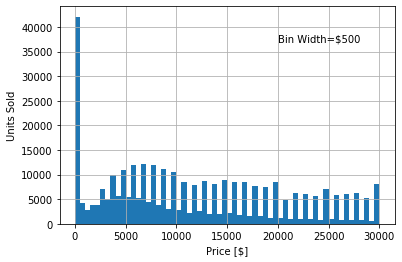

In [421]:
plt.figure()
plt.hist(df['price'], bins=np.linspace(0, 3e4, 61))
plt.xlabel('Price [$]')
plt.ylabel('Units Sold')
plt.grid()
plt.text(2e4, 3.7e4, 'Bin Width=$%i'%500)
plt.savefig('images/Price_Distribution.png', dpi=150)

##### The comb-tooth nature of the data is something I presumed initially to be doing bad binnings of the data, but I believe now the data are real¶
##### This is likely due to the tendency of the sales to be XXX9.99.
##### In the data below bin-widths are 500 dollars so the sales are happening just shy of an integer multiple of 1000 dollars

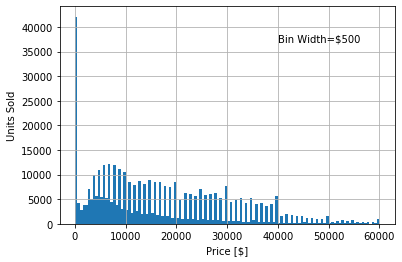

In [422]:
plt.figure()
plt.hist(df['price'], bins=np.linspace(0, 6e4, 121))
plt.xlabel('Price [$]')
plt.ylabel('Units Sold')
plt.grid()
plt.text(4e4, 3.7e4, 'Bin Width=$%i'%500)
plt.savefig('images/Price_Distribution2.png', dpi=150)

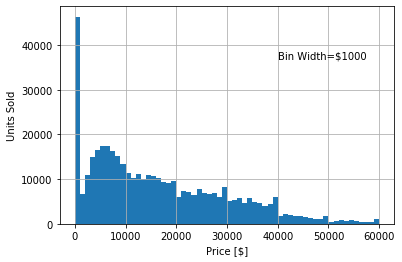

In [423]:
plt.figure()
plt.hist(df['price'], bins=np.linspace(0, 6e4, 61))
plt.xlabel('Price [$]')
plt.ylabel('Units Sold')
plt.grid()
plt.text(4e4, 3.7e4, 'Bin Width=$%i'%1000)
plt.savefig('images/Price_Distribution3.png', dpi=150)

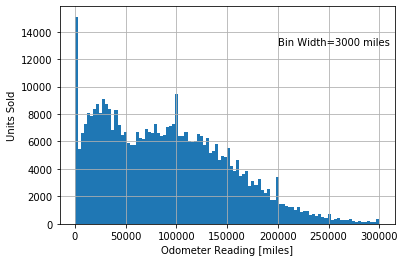

In [424]:
plt.figure()
plt.hist(df['odometer'], bins=np.linspace(0, 3.0e5, 101))
plt.xlabel('Odometer Reading [miles]')
plt.ylabel('Units Sold')
plt.grid()
plt.text(2e5, 1.3e4, 'Bin Width=%i miles'%3000)
plt.savefig('images/Odometer_Distribution.png', dpi=150)

In [425]:
# Note, a sort of tri-modality in odometer readings:
# 1) Never really driven, 0-3000 miles extremely narrow distribution
# 2) ~21k - 33k, lightly driven, slightly wider distribution 
# 3) 50k ->, driven for a long time, this distribution is very wide and centered around ~100k

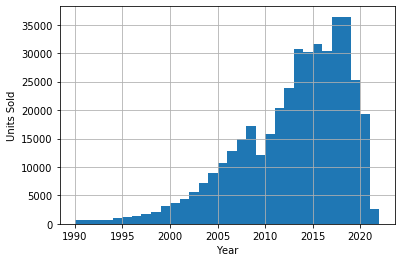

In [426]:
plt.figure()
plt.hist(df['year'], bins=np.linspace(1990, 2022, 33))
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.grid()
#plt.text(2e5, 1.3e4, 'Bin Width=%i miles'%3000)
plt.savefig('images/Year_Distribution.png', dpi=150)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

118247
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
ML32A3HJXHH020468      1
3GNAL2EK5DS608409      1
2FMPK4J92HBC53520      1
1C6RR7TM0GS140107      1
4T1BF1FKXCU597981      1
Name: VIN, Length: 118246, dtype: int64


Text(0.5, 0, 'images/Number of Sales of Unique VIN')

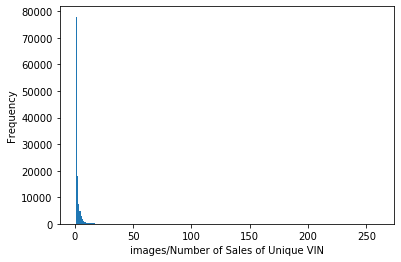

In [427]:
df.head()
print(len(df['VIN'].unique()))
print(df['VIN'].value_counts())
df['VIN'].value_counts().plot(kind='hist', bins=np.linspace(0, 261, 262))
plt.xlabel('images/Number of Sales of Unique VIN')

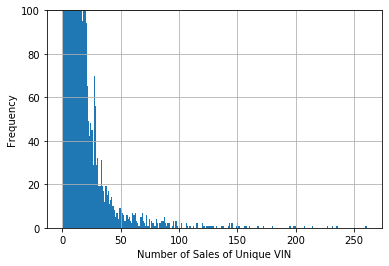

In [428]:
df['VIN'].value_counts().plot(kind='hist', bins=np.linspace(0, 261, 262))
plt.xlabel('Number of Sales of Unique VIN')
plt.ylim(0, 100)
plt.grid()
plt.savefig('images/Unique-VIN_Sales_Distribution2.png', dpi=150)

In [429]:
print(df[df['VIN']=='1FMJU1JT1HEA52352'].describe())

                 id    price    year  odometer
count  2.610000e+02    261.0   261.0     261.0
mean   7.311842e+09  29590.0  2017.0   70760.0
std    5.670758e+04      0.0     0.0       0.0
min    7.311767e+09  29590.0  2017.0   70760.0
25%    7.311795e+09  29590.0  2017.0   70760.0
50%    7.311833e+09  29590.0  2017.0   70760.0
75%    7.311878e+09  29590.0  2017.0   70760.0
max    7.312005e+09  29590.0  2017.0   70760.0


In [430]:
print(df[df['VIN']=='3C6JR6DT3KG560649'].describe())

                 id    price    year  odometer
count  2.350000e+02    235.0   235.0     235.0
mean   7.312880e+09  25990.0  2019.0   12302.0
std    7.602829e+05      0.0     0.0       0.0
min    7.311768e+09  25990.0  2019.0   12302.0
25%    7.311878e+09  25990.0  2019.0   12302.0
50%    7.313309e+09  25990.0  2019.0   12302.0
75%    7.313356e+09  25990.0  2019.0   12302.0
max    7.314829e+09  25990.0  2019.0   12302.0


In [431]:
print(df['VIN'].value_counts().describe())

count    118246.000000
mean          2.248178
std           4.993355
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         261.000000
Name: VIN, dtype: float64


##### Because most of the vehicle data are 1-time sales, but there is the possibility of a legitimate second or nth sale, I will drop duplicate entries of VIN, odometer reading, and price

In [432]:
df = df.drop_duplicates(['VIN', 'odometer', 'price'])
df['VIN'].value_counts()

2D4GV77387S671809    10
1.07044E+13           9
0                     8
3C4PDCAB9HT529613     6
WVWBA71F38V029590     5
                     ..
KNDCB3LC3M5464911     1
2C3CDXHG5EH254595     1
1C4BJWFG8EL274646     1
WDBFA61E3LF005956     1
4T1BF1FKXCU597981     1
Name: VIN, Length: 118246, dtype: int64

                 id        price         year      odometer
count  1.000000e+01    10.000000    10.000000      10.00000
mean   7.314893e+09   988.500000  2014.800000   63619.00000
std    1.784623e+06   218.263984     1.316561   18757.88787
min    7.311256e+09   700.000000  2013.000000   42322.00000
25%    7.313997e+09   773.750000  2014.000000   50507.25000
50%    7.315355e+09   995.000000  2015.000000   59663.00000
75%    7.316154e+09  1200.000000  2016.000000   77573.25000
max    7.316669e+09  1200.000000  2016.000000  100011.00000


Text(0.5, 0, 'Odometer')

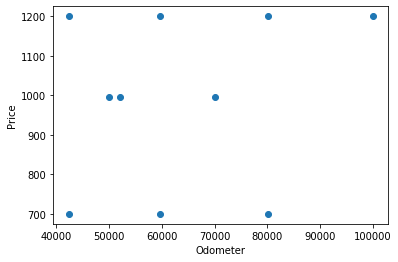

In [433]:
print(df[df['VIN']=='2D4GV77387S671809'].describe())
plt.plot(df[df['VIN']=='2D4GV77387S671809']['odometer'], df[df['VIN']=='2D4GV77387S671809']['price'], 'o')
plt.ylabel('Price')
plt.xlabel('Odometer')

##### The data on multiple sales seem unreliable so I am going to just drop any duplicate sales

In [434]:
# As mentioned earlier I don't believe that regional data will be relevant to a given dealer (I'll maintain state academically)
# VIN has too many unique entries to be of real predictive value, though curiously some cars were sold over 100 times
print(df.describe())
df_ = df.drop_duplicates(['VIN'])
print(df_.describe())
#df = df.drop(['region', 'VIN'])

                 id         price           year      odometer
count  2.117710e+05  2.117710e+05  211090.000000  2.097480e+05
mean   7.312192e+09  1.170476e+05    2010.245938  1.078669e+05
std    4.360829e+06  1.599815e+07      10.088223  2.326420e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.309471e+09  5.450000e+03    2007.000000  4.772000e+04
50%    7.313674e+09  1.140000e+04    2013.000000  9.457700e+04
75%    7.315625e+09  2.099900e+04    2016.000000  1.401542e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07
                 id         price           year      odometer
count  1.182470e+05  1.182470e+05  117653.000000  1.166710e+05
mean   7.312179e+09  1.782777e+04    2012.661037  9.013283e+04
std    4.239264e+06  3.599125e+05       6.808482  9.664870e+04
min    7.222696e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.309408e+09  6.000000e+03    2010.000000  4.022550e+04
50%    7.313622e+09  1.322200e+04    2014.000000  8.441

##### I am now content that the data are sufficiently clean, and we have a sense of the important distributions, now I'll prepare it for modelling

In [435]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118247 entries, 0 to 426833
Data columns (total 18 columns):
id              118247 non-null int64
region          118247 non-null object
price           118247 non-null int64
year            117653 non-null float64
manufacturer    115179 non-null object
model           117542 non-null object
condition       61082 non-null object
cylinders       70266 non-null object
fuel            116608 non-null object
odometer        116671 non-null float64
title_status    114608 non-null object
transmission    117010 non-null object
VIN             118246 non-null object
drive           90898 non-null object
size            30310 non-null object
type            102062 non-null object
paint_color     87564 non-null object
state           118247 non-null object
dtypes: float64(2), int64(2), object(14)
memory usage: 17.1+ MB


In [436]:
df_.drop(['id', 'state', 'region', 'VIN', 'size', 'paint_color'], axis=1).info()
df__ = df_.drop(['id', 'state', 'region', 'VIN', 'size', 'paint_color'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118247 entries, 0 to 426833
Data columns (total 12 columns):
price           118247 non-null int64
year            117653 non-null float64
manufacturer    115179 non-null object
model           117542 non-null object
condition       61082 non-null object
cylinders       70266 non-null object
fuel            116608 non-null object
odometer        116671 non-null float64
title_status    114608 non-null object
transmission    117010 non-null object
drive           90898 non-null object
type            102062 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 11.7+ MB


In [437]:
df__['cylinders'].unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       '10 cylinders', '3 cylinders', '12 cylinders', 'other'],
      dtype=object)

In [438]:
# Check for capacity to one-Hot encode the categorical variables
columns = df__.columns
i = -1
for entry in df__.dtypes:
    i += 1
    column = columns[i]
    if entry == object:
        print(len(df__[column].unique()))
    else:
        print('no')

no
no
42
17550
7
9
6
no
7
4
4
14


##### In the interest of restricting the number of columns we absolutely must drop the "model" category

In [439]:
df___ = df__.drop(['model'], axis=1)
print(df___.dropna().info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34875 entries, 32 to 426833
Data columns (total 11 columns):
price           34875 non-null int64
year            34875 non-null float64
manufacturer    34875 non-null object
condition       34875 non-null object
cylinders       34875 non-null object
fuel            34875 non-null object
odometer        34875 non-null float64
title_status    34875 non-null object
transmission    34875 non-null object
drive           34875 non-null object
type            34875 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 3.2+ MB
None


##### Even with the reduced column numbers, it's too soon to drop NaN values. It looks like we'd do better to drop one or two columns with disproportionate numbers of NaN values (discarding 2/11 columns rather than ~7/10 rows)

In [440]:
df____ = df___.drop(['condition', 'cylinders'], axis=1)
print(df____.dropna().info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76586 entries, 32 to 426833
Data columns (total 9 columns):
price           76586 non-null int64
year            76586 non-null float64
manufacturer    76586 non-null object
fuel            76586 non-null object
odometer        76586 non-null float64
title_status    76586 non-null object
transmission    76586 non-null object
drive           76586 non-null object
type            76586 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 5.8+ MB
None


##### About 1/4 of the original dataset is left here but we have 9 columns of complete data so hopefully the smaller dataset is compensated by better quality

##### Now I'm going to one-hot encode the categorical data and move to modeling

In [441]:
df = df____.dropna().reset_index()

# Execute one-Hot encode the categorical variables
columns = df.columns
i = -1
for entry in df.dtypes:
    i += 1
    column = columns[i]
    if entry == object:
        one_hot = pd.get_dummies(df[column])
        df = pd.concat([df, one_hot], axis=1)
        df = df.drop(column,axis = 1)
    else:
        continue
        
df = df.drop('index', axis=1)

In [442]:
print(one_hot)
print(df)
#df.to_excel('C:\\Users\\geoffrey.sitwell\\Downloads\\practical_application_II-starter\\testing.xlsx')

       SUV  bus  convertible  coupe  hatchback  mini-van  offroad  other  \
0        0    0            0      0          0         0        0      0   
1        0    0            0      0          0         0        0      0   
2        0    0            0      0          0         0        0      0   
3        0    0            0      0          0         0        0      1   
4        0    0            0      0          0         0        0      1   
...    ...  ...          ...    ...        ...       ...      ...    ...   
76581    0    0            0      0          0         0        0      0   
76582    0    0            0      0          0         0        0      0   
76583    0    0            0      0          0         0        0      0   
76584    0    0            0      0          0         0        0      1   
76585    0    0            1      0          0         0        0      0   

       pickup  sedan  truck  van  wagon  
0           1      0      0    0      0  
1  

In [443]:
# Check the number of expected columns
columns = df____.columns
i = -1
sum_ = 0
for entry in df____.dtypes:
    i += 1
    column = columns[i]
    if entry == object:
        sum_ += len(df____[column].unique()) - 1
        #print(len(df____[column].unique()) - 1)
    else:
        sum_ += 1
        print('no')
        
print(sum_)

no
no
no
74


In [444]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76586 entries, 0 to 76585
Data columns (total 74 columns):
price              76586 non-null int64
year               76586 non-null float64
odometer           76586 non-null float64
acura              76586 non-null uint8
alfa-romeo         76586 non-null uint8
aston-martin       76586 non-null uint8
audi               76586 non-null uint8
bmw                76586 non-null uint8
buick              76586 non-null uint8
cadillac           76586 non-null uint8
chevrolet          76586 non-null uint8
chrysler           76586 non-null uint8
datsun             76586 non-null uint8
dodge              76586 non-null uint8
ferrari            76586 non-null uint8
fiat               76586 non-null uint8
ford               76586 non-null uint8
gmc                76586 non-null uint8
harley-davidson    76586 non-null uint8
honda              76586 non-null uint8
hyundai            76586 non-null uint8
infiniti           76586 non-null uint8
jaguar 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [445]:
df = df.reset_index()
df = df.drop(['index'], axis=1)

# Separate the dependent/independent variables
X = df.drop('price', axis = 1)
y = df['price']
# Separate the data into train and test data and get the indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
trainIndices = X_train.index
testIndices = X_test.index

In [446]:
X

,year,odometer,acura,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,...,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon
0,2012.0,68696.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2016.0,29499.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2016.0,17302.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,2011.0,30237.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2017.0,30041.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76581,2019.0,15113.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76582,2005.0,172511.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76583,2005.0,185000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76584,2004.0,186000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Scaled Polynomial Ridge Regressor

1
2


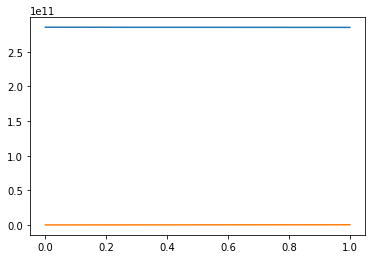

In [447]:
# Find the best polynomial degree
trainMSEs = []
testMSEs = []

# Tried 1 - 4 but Memory Error at degree 3
for i in range(1,3):
    print(i)
    scaled_ridge_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree = i, include_bias = False)),
        ('scale', StandardScaler()),
        ('ridge', Ridge())
        ])
    scaled_ridge_model.fit(X_train, y_train)
    
    pred_train = scaled_ridge_model.predict(X_train)
    pred_test = scaled_ridge_model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, pred_train)
    test_mse = mean_squared_error(y_test, pred_test)
    
    trainMSEs.append(train_mse)
    testMSEs.append(test_mse)
    
plt.figure()
plt.plot(trainMSEs)
plt.plot(testMSEs)

In [448]:
print(trainMSEs)

[285241303921.907, 285036242300.3059]


##### With these models being effectively equivalent I'm going to use the simpler 1-degree model

In [449]:
scaled_ridge_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree = 1, include_bias = False)),
        ('scale', StandardScaler()),
        ('ridge', Ridge())
        ])

##### K-fold cross-validation with k=5

In [450]:
search_params = {'ridge__alpha': 10**np.linspace(-5, 5, 101)}

grid = GridSearchCV(estimator=scaled_ridge_model,
                           param_grid = search_params,
                           cv=5)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [451]:
#print(len(best_model[2].coef_), len(df.columns))
#print(df.columns)

d = {'Coefficient':best_model[2].coef_, 'Name':X_train.columns}
modelDF = pd.DataFrame(d)

modelDF.sort_values(by='Coefficient')#.head()

,Coefficient,Name
1,-1763.297722,odometer
32,-792.445651,nissan
18,-744.002109,honda
60,-732.093869,SUV
19,-648.335779,hyundai
...,...,...
13,681.294706,ferrari
68,682.672806,pickup
43,1106.759027,diesel
0,2251.096200,year


In [452]:
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)

model_2_best_alpha = grid.best_params_

print(f'Test MSE: {model_2_test_mse}')
print(f'Best Alpha: {list(model_2_best_alpha.values())[0]}')

Test MSE: 183351862.7281831
Best Alpha: 63095.73444801943


In [453]:
print('%.2e'%model_2_train_mse, '%.2e'%model_2_test_mse)

2.85e+11 1.83e+08


#### Sequential Feature Selection

In [454]:
# SFS Model
model_SFS = Pipeline([
    ('scale', StandardScaler()),
    ('selector', SequentialFeatureSelector(estimator = Lasso(), scoring='neg_mean_squared_error', cv=[[trainIndices, testIndices]], n_features_to_select = 6)),
    ('ridge', Ridge())
])

model_SFS.fit(X, y)
    
pred_train = model_SFS.predict(X_train)
pred_test = model_SFS.predict(X_test)
    
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

#print(model_SFS[:-1].get_feature_names_out())
#print(model_SFS[-1].coef_)

In [455]:
d = {'Coefficient':model_SFS[-1].coef_, 'Name':model_SFS[:-1].get_feature_names_out()}
modelDF = pd.DataFrame(d)

modelDF.head()

#print('%.2e'%train_mse, '%.2e'%test_mse)

,Coefficient,Name
0,5109.954206,year
1,2411.259937,diesel
2,1185.029988,other
3,-1652.981237,fwd
4,2144.874372,pickup


#### RFE

In [456]:
# Scaled Lasso RFE
###scaled_lasso_rfe_model = Pipeline([
###     ('scale', StandardScaler()),
###     ('selector', RFE(estimator = Lasso(), n_features_to_select = 4)),
###     ('ridge', Ridge())
###     ])

###scaled_lasso_rfe_model.fit(X_train, y_train)
    
###pred_train = scaled_lasso_rfe_model.predict(X_train)
###pred_test = scaled_lasso_rfe_model.predict(X_test)
    
###train_mse = mean_squared_error(y_train, pred_train)
###test_mse = mean_squared_error(y_test, pred_test)

###print(scaled_lasso_rfe_model[:-1].get_feature_names_out())

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Although the model test errors are higher than I would like, I think there are still useful conclusionst that can be drawn from the data. In particular we can determine that the greatest predictors of price are whether it's a Chevy, the odometer reading, the year of the car and whether it is a diesel.

The most powerful predictors of the price are whether the vehicle is a Chevrolet and the odometer reading which functions a proxy for vehicle wear and tear. The influence that the Chevy brand has over the price may be an indication that these vehicle maintain their value particularly well. It may also be an indication that Chevy vehicles are generally more expensive as we can also see that whether the vehicle is a Ferrari strongly indicates the price. Japanese car brands like Honda and Nissan negatively correlate with expense by contrast.

The other factors driving price are the year and whether the vehicle is a diesel or not. The diesel category may be a spurious correlation as diesel vehicles are more likely to be larger vehicles like semi-trucks which are more-expensive but not necessarily sold at high-volume. The fact that year positively correlates with cost is fun, as it's equivalent to saying younger cars are more expensive which matches intuition.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### What make of vehicles should we be selling?

Chevrolet makes are likely to sell for higher prices and makes like Hyundai, Honda and Nissan are likely to sell for less. This may be a broader indication that domestic brands sell for more than foreign brands.

#### What type of vehicles should we sell?

Work vehicles like pickup trucks, specifically diesel trucks sell for relatively high prices. More domestic vehicles like SUVs tend not to sell for as much.

But it is not sufficient to consider how much a vehicle sells for; the volume of sales is also a critical consideration!

From the earlier exploration of the data we can see that the volume of sales is greatest for vehicles approximately 3-4 years old (years 2018-2019), and with very low odometer readings. 

![](images/Year_Distribution.png)

![](images/Odometer_Distribution.png)

It is unclear whether the data provided cover exclusively used car sales though, so omitting the spike at very low odometer readings it is interesting to note the multi-moded odometer sales.

Given the volume of sales at ~25k-30k, and the negative relationship of odometer readings on price it seems this is the ideal zone.

### Conclusion

This investigation makes no consideration of the cost of procuring inventory, but for gross profits dealerships should focus on:

#### 1) Domestic Work Vehicles
#### 2) Low Odometer Readings 
#### 3) Few years old

These variables taken in conjunction will help to maximize gross profits through by maximizing volume of sales and sale prices.

### Final Note

I would also advise potential clients to maintain the pricing scheme of pricing just below integer multiples of $1000.
Although the distribution in sales by price may be a consequence of the volume of vehicles at those prices rather than customers propensity towards those prices, without that data in hand we need to assume the pricing sheme works to increase sales.

![](images/Price_Distribution.png)